In [6]:
!pip install keras-preprocessing
!pip install --upgrade tensorflow
!pip install opencv-contrib-python

In [7]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model



from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import preprocessing


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [8]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [17]:
!curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10246  100 10246    0     0  16456      0 --:--:-- --:--:-- --:--:-- 16446


In [18]:
!pip install kaggle

In [20]:
!pip install kagglehub

In [21]:
import kagglehub

path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

100%|██████████| 312M/312M [00:35<00:00, 9.19MB/s] 

Extracting files...


In [22]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [23]:
dataset = path
walk_through_dir(dataset)

There are 23 directories and 0 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5'.
There are 0 directories and 478 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Seahorse'.
There are 0 directories and 579 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Sea Urchins'.
There are 0 directories and 497 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Clams'.
There are 0 directories and 1903 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Turtle_Tortoise'.
There are 0 directories and 782 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Dolphin'.
There are 0 directories and 845 images in '/Users/senaleevisal/.cache/kagglehub/datasets/vencerlanz09/s

In [24]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [25]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/var/folders/s7/5c15vr457zzd8hd9nbd5vx3h0000gn/T/ipykernel_53698/322025102.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


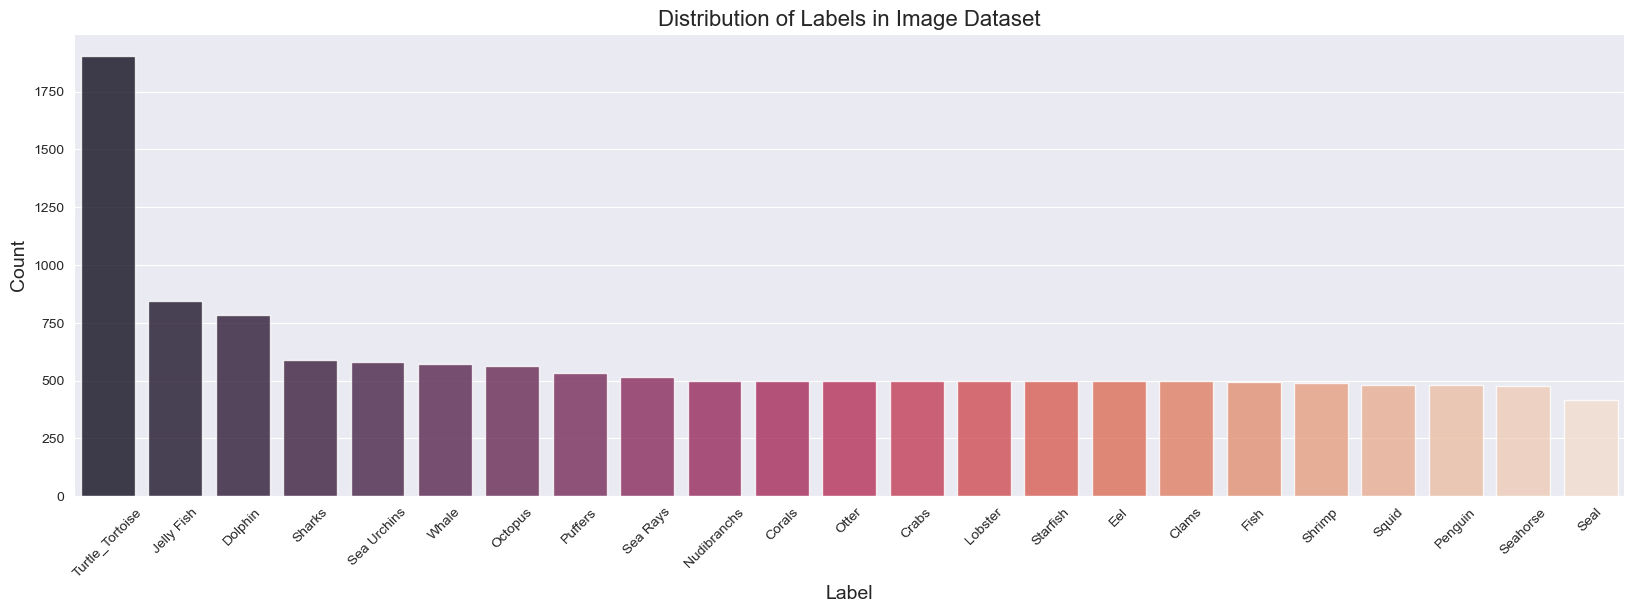

In [26]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

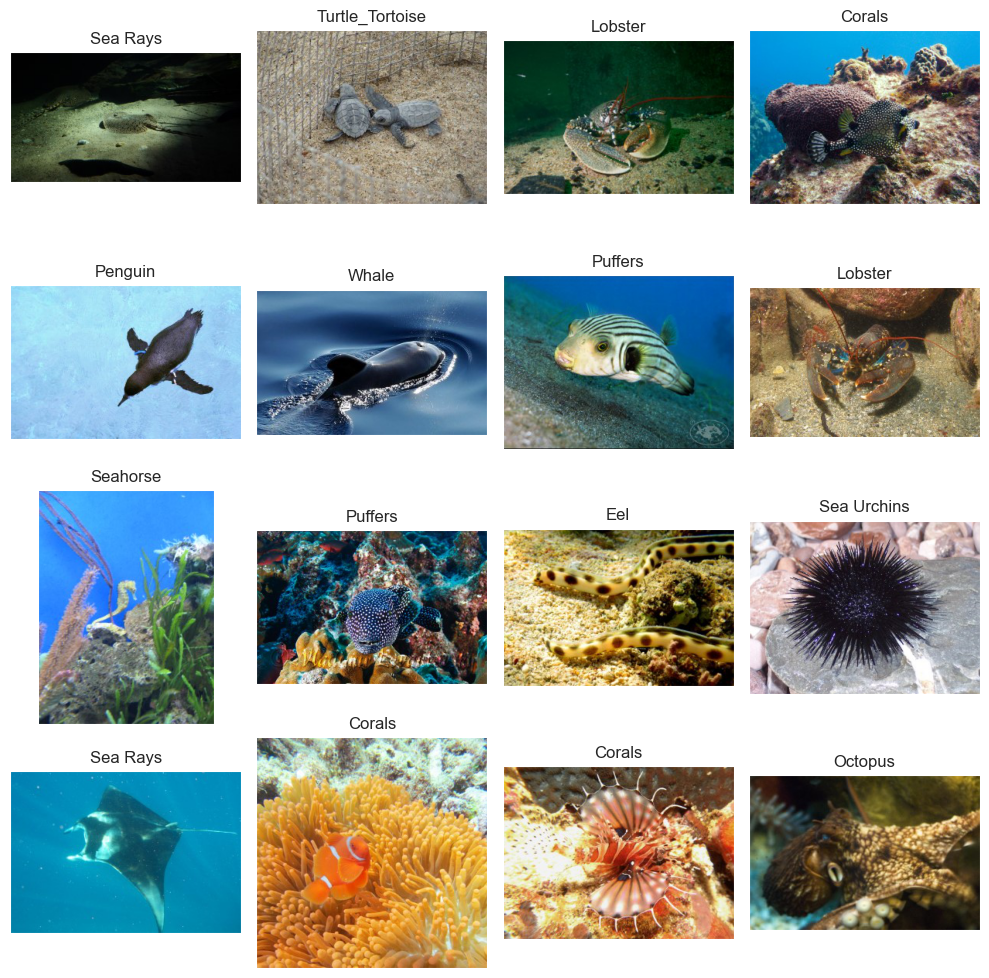

In [27]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [28]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

In [29]:
coralpath = os.path.join(dataset, 'Corals')

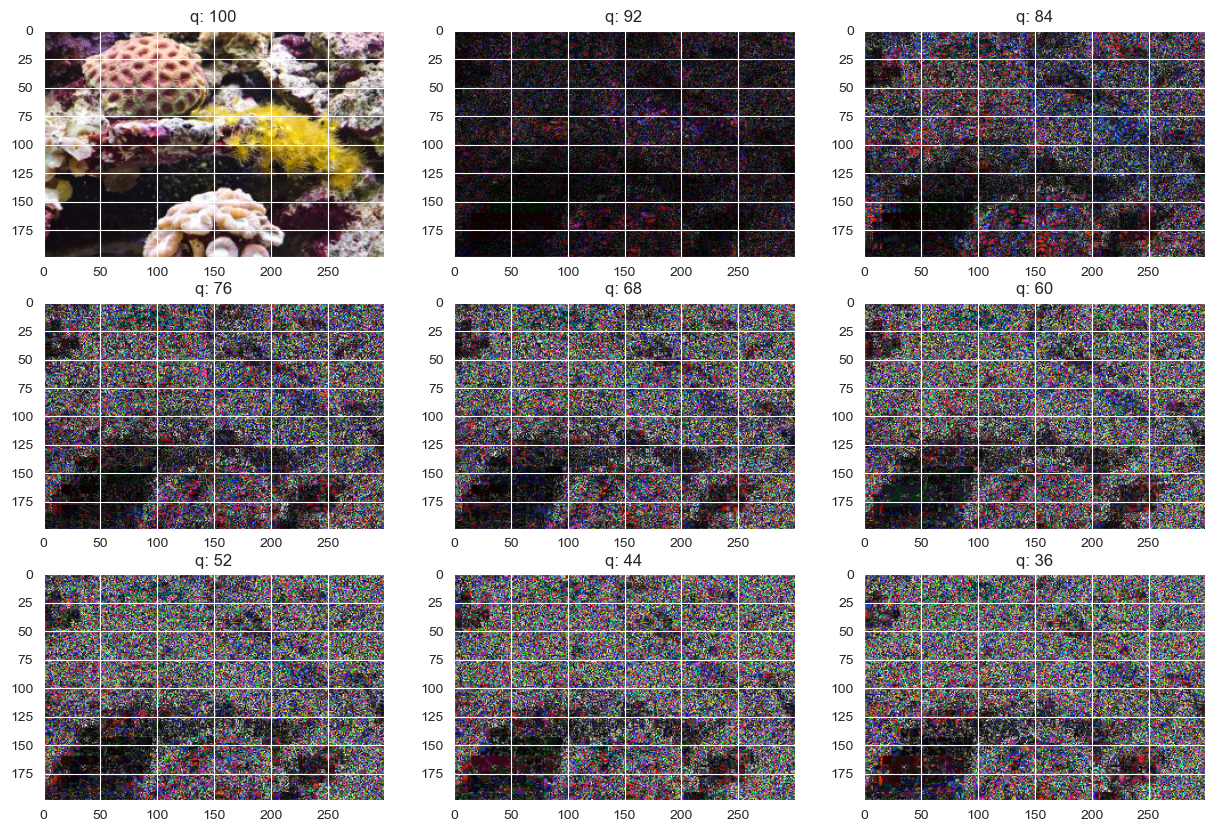

In [30]:
# View random sample from the dataset
p = random_sample(coralpath)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [31]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [32]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [33]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8775 validated image filenames belonging to 23 classes.
Found 2193 validated image filenames belonging to 23 classes.
Found 2743 validated image filenames belonging to 23 classes.


In [34]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [35]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(224, 224),              # Resize images to 224x224
  layers.Rescaling(1./255),                # Normalize images to the range [0, 1]
  layers.RandomFlip("horizontal"),        # Random horizontal flip
  layers.RandomRotation(0.1),             # Random rotation by 10%
  layers.RandomZoom(0.1),                 # Random zoom
  layers.RandomContrast(0.1),             # Random contrast adjustment
])


In [36]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


In [37]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoints.weights.h5" # Add .weights.h5 to the filepath
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [38]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [41]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20250315-175304
Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.0475 - loss: 5.0957 - val_accuracy: 0.2358 - val_loss: 2.9075
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.1140 - loss: 3.1176 - val_accuracy: 0.3128 - val_loss: 2.7311
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.1687 - loss: 2.9063 - val_accuracy: 0.3625 - val_loss: 2.5515
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.2067 - loss: 2.7704 - val_accuracy: 0.4232 - val_loss: 2.3666
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.2323 - loss: 2.6488 - val_accuracy: 0.4546 - val_loss: 2.2069
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.2838 - loss: 2.5175 - val_accuracy: 0.4998 - val_loss: 2.0687
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.3084 - loss: 2.4262 - val_accuracy: 0.5299 - val_loss: 1.9525
Epoch 8/20
2

In [43]:
model.save_weights('animals_eff.weights.h5')

In [44]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 1.21835
Test Accuracy: 69.16%


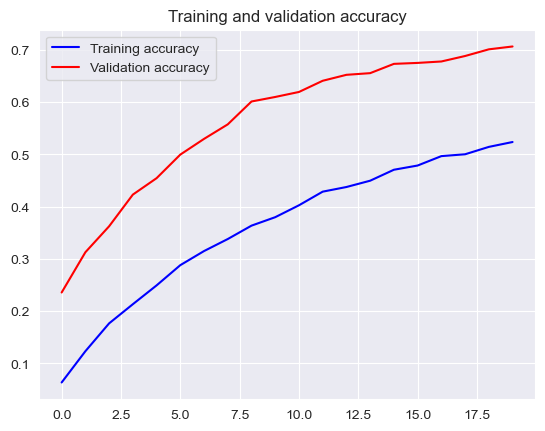

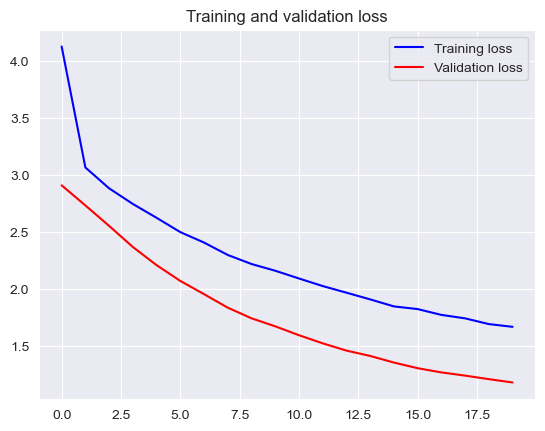

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

86/86 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step
The first 5 predictions: ['Eel', 'Clams', 'Nudibranchs', 'Shrimp', 'Whale']


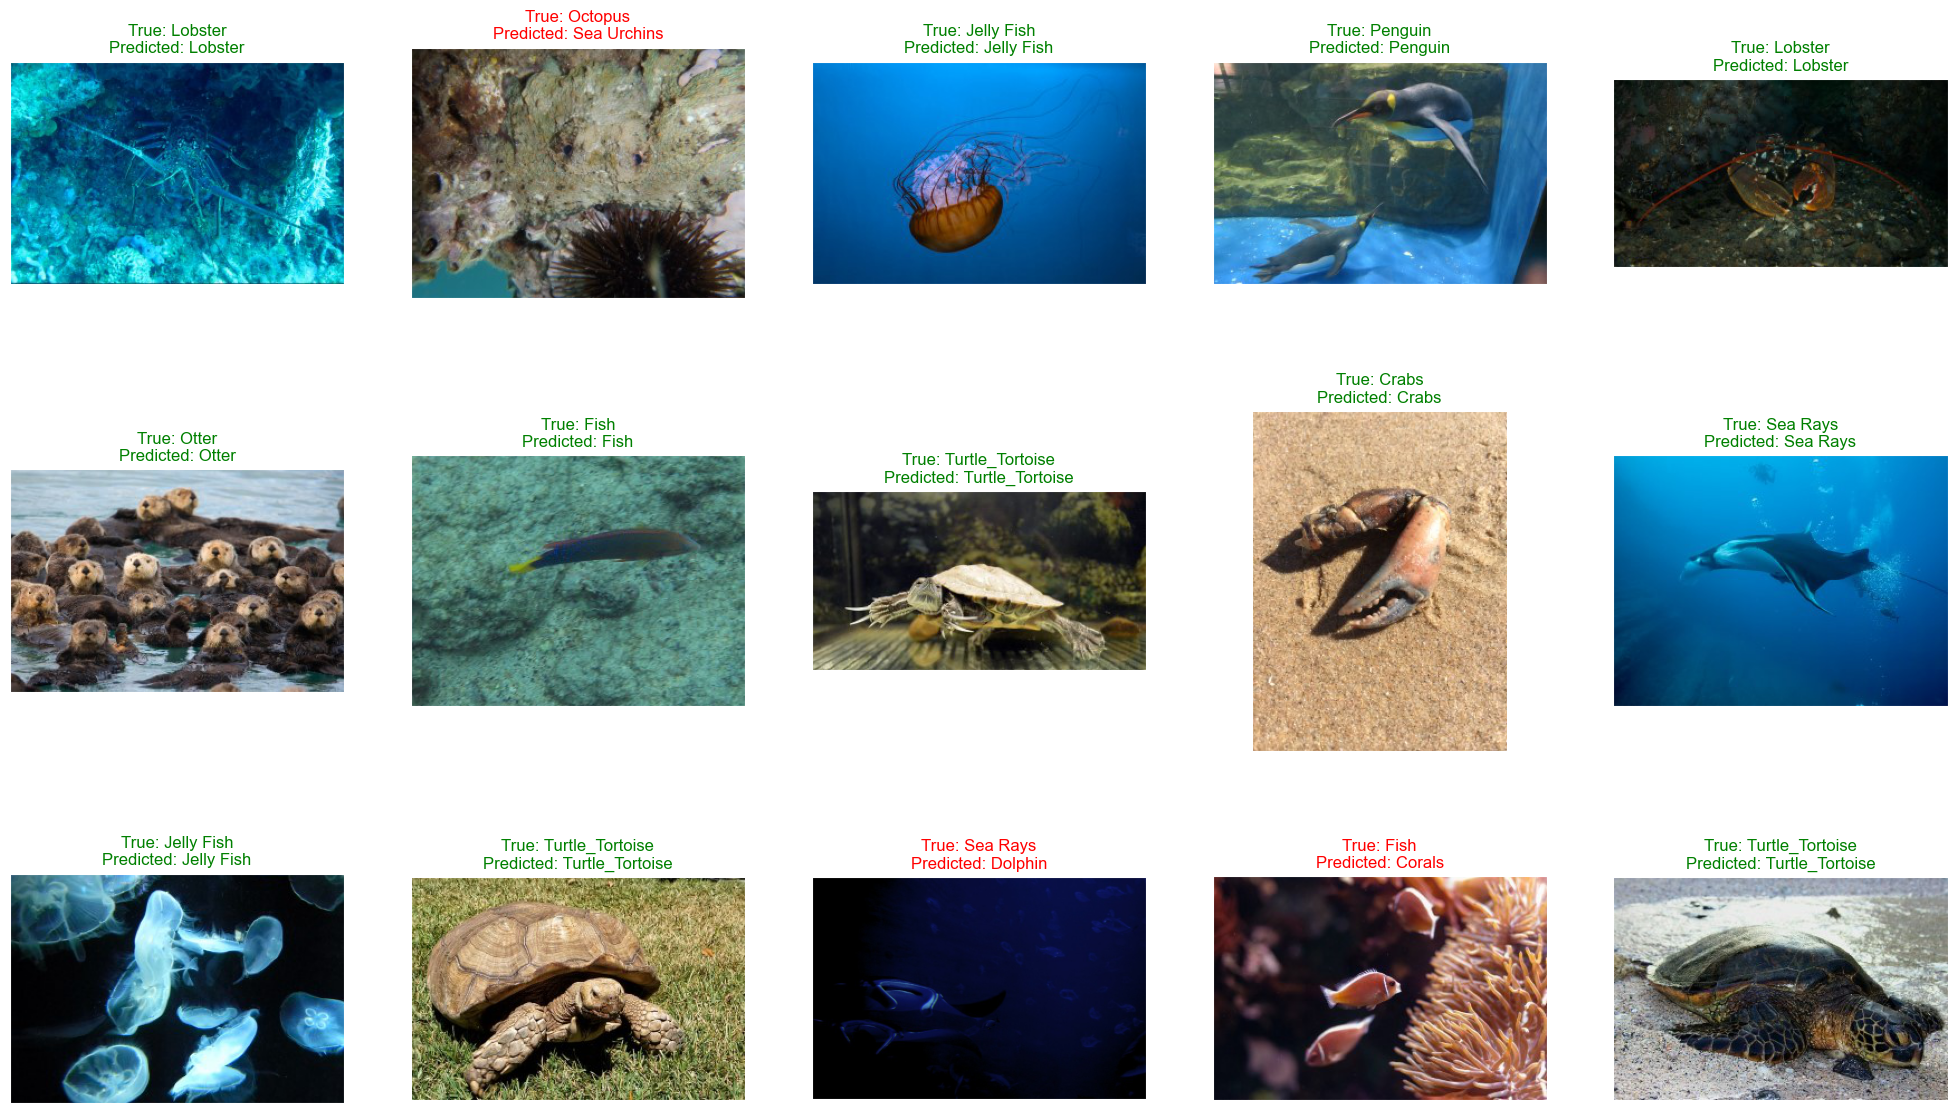

<Figure size 640x480 with 0 Axes>

In [47]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [48]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

          Clams       0.41      0.47      0.43       103
         Corals       0.34      0.71      0.46        91
          Crabs       0.83      0.97      0.90       103
        Dolphin       0.58      0.78      0.66       169
            Eel       0.66      0.62      0.64        91
           Fish       0.81      0.45      0.58       111
     Jelly Fish       0.79      0.99      0.88       162
        Lobster       0.63      0.59      0.61       105
    Nudibranchs       0.79      0.69      0.74       109
        Octopus       0.31      0.24      0.27       102
          Otter       0.95      0.99      0.97        97
        Penguin       0.85      0.68      0.76        82
        Puffers       0.62      0.64      0.63       106
       Sea Rays       0.70      0.70      0.70        99
    Sea Urchins       0.90      0.96      0.93       116
       Seahorse       0.66      0.23      0.34       107
           Seal       0.90    

In [49]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Clams             0.406780  0.466019  0.434389   103.000000
Corals            0.335052  0.714286  0.456140    91.000000
Crabs             0.833333  0.970874  0.896861   103.000000
Dolphin           0.579646  0.775148  0.663291   169.000000
Eel               0.658824  0.615385  0.636364    91.000000
Fish              0.806452  0.450450  0.578035   111.000000
Jelly Fish        0.788177  0.987654  0.876712   162.000000
Lobster           0.632653  0.590476  0.610837   105.000000
Nudibranchs       0.789474  0.688073  0.735294   109.000000
Octopus           0.311688  0.235294  0.268156   102.000000
Otter             0.950495  0.989691  0.969697    97.000000
Penguin           0.848485  0.682927  0.756757    82.000000
Puffers           0.623853  0.641509  0.632558   106.000000
Sea Rays          0.696970  0.696970  0.696970    99.000000
Sea Urchins       0.902439  0.956897  0.928870   116.000000
Seahorse          0.657895  0.233645  0.344828   107.000000
Seal              0.896104  0.711340  0.793103    97.000000
Sharks            0.620155  0.727273  0.669456   110.000000
Shrimp            0.324675  0.263158  0.290698    95.000000
Squid             0.608696  0.160920  0.254545    87.000000
Starfish          0.868421  1.000000  0.929577    99.000000
Turtle_Tortoise   0.842593  0.957895  0.896552   380.000000
Whale             0.649351  0.409836  0.502513   122.000000
accuracy          0.691579  0.691579  0.691579     0.691579
macro avg         0.679661  0.648944  0.644444  2743.000000
weighted avg      0.697743  0.691579  0.677225  2743.000000

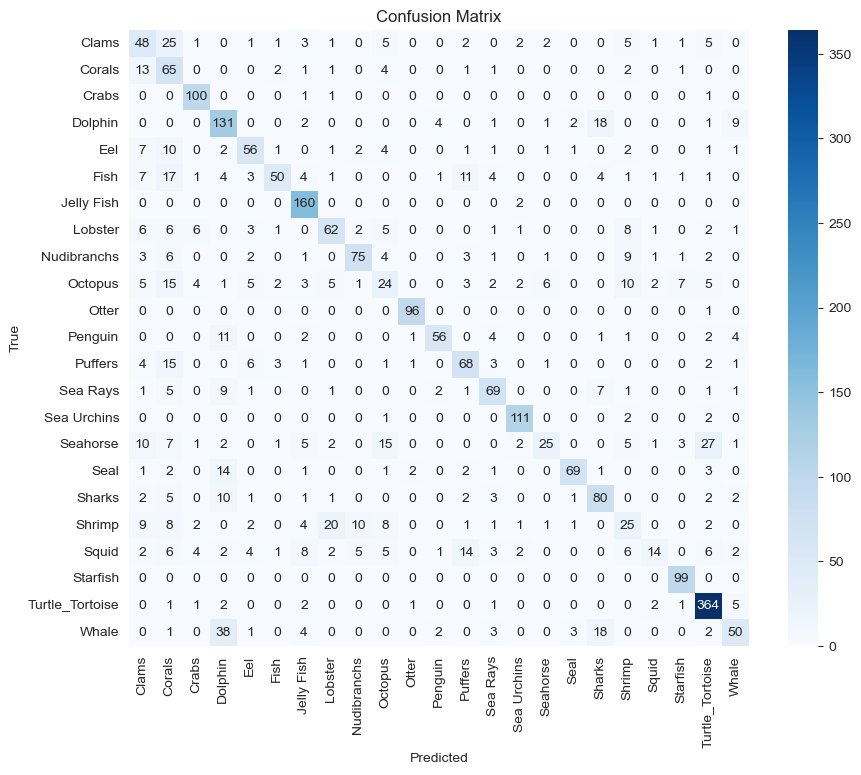

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def make_confusion_matrix(y_true, y_pred, classes):
	cm = confusion_matrix(y_true, y_pred, labels=classes)
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title('Confusion Matrix')
	plt.show()

make_confusion_matrix(y_test, pred, list(labels.values()))


In [52]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/var/folders/s7/5c15vr457zzd8hd9nbd5vx3h0000gn/T/ipykernel_53698/4154522804.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


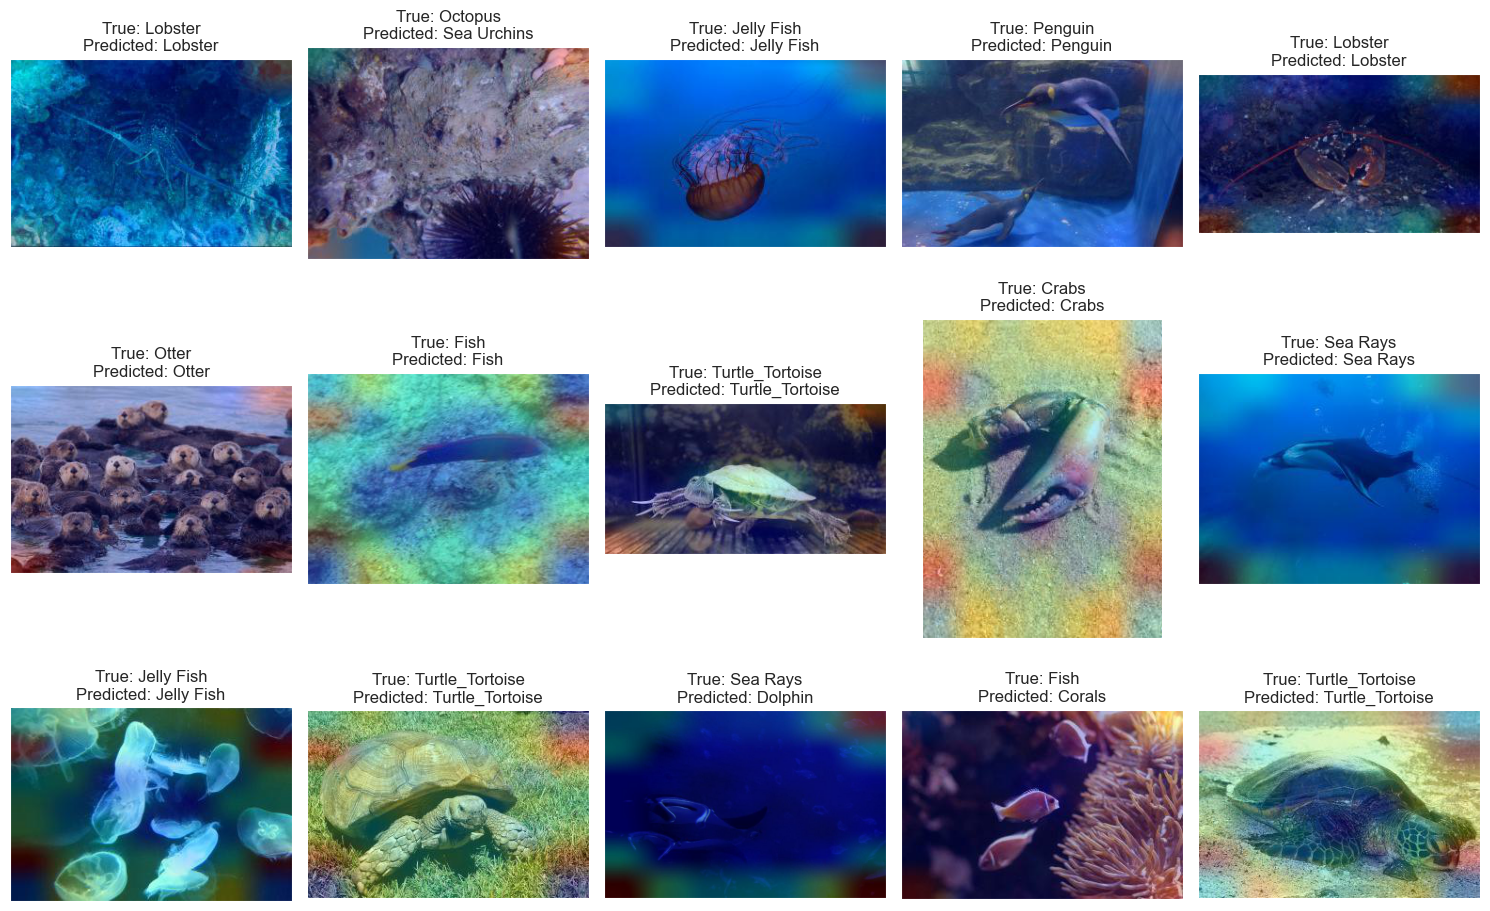

In [53]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
def predict_image(image_path, model, class_labels):
    # Load and preprocess the image
    img_array = get_img_array(image_path, size=TARGET_SIZE)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Get the class label
    predicted_label = class_labels[predicted_class[0]]
    
    return predicted_label

# Example usage
image_path = '/path/to/your/image.jpg'
predicted_label = predict_image(image_path, model, class_labels)
print(f'The predicted label for the image is: {predicted_label}')

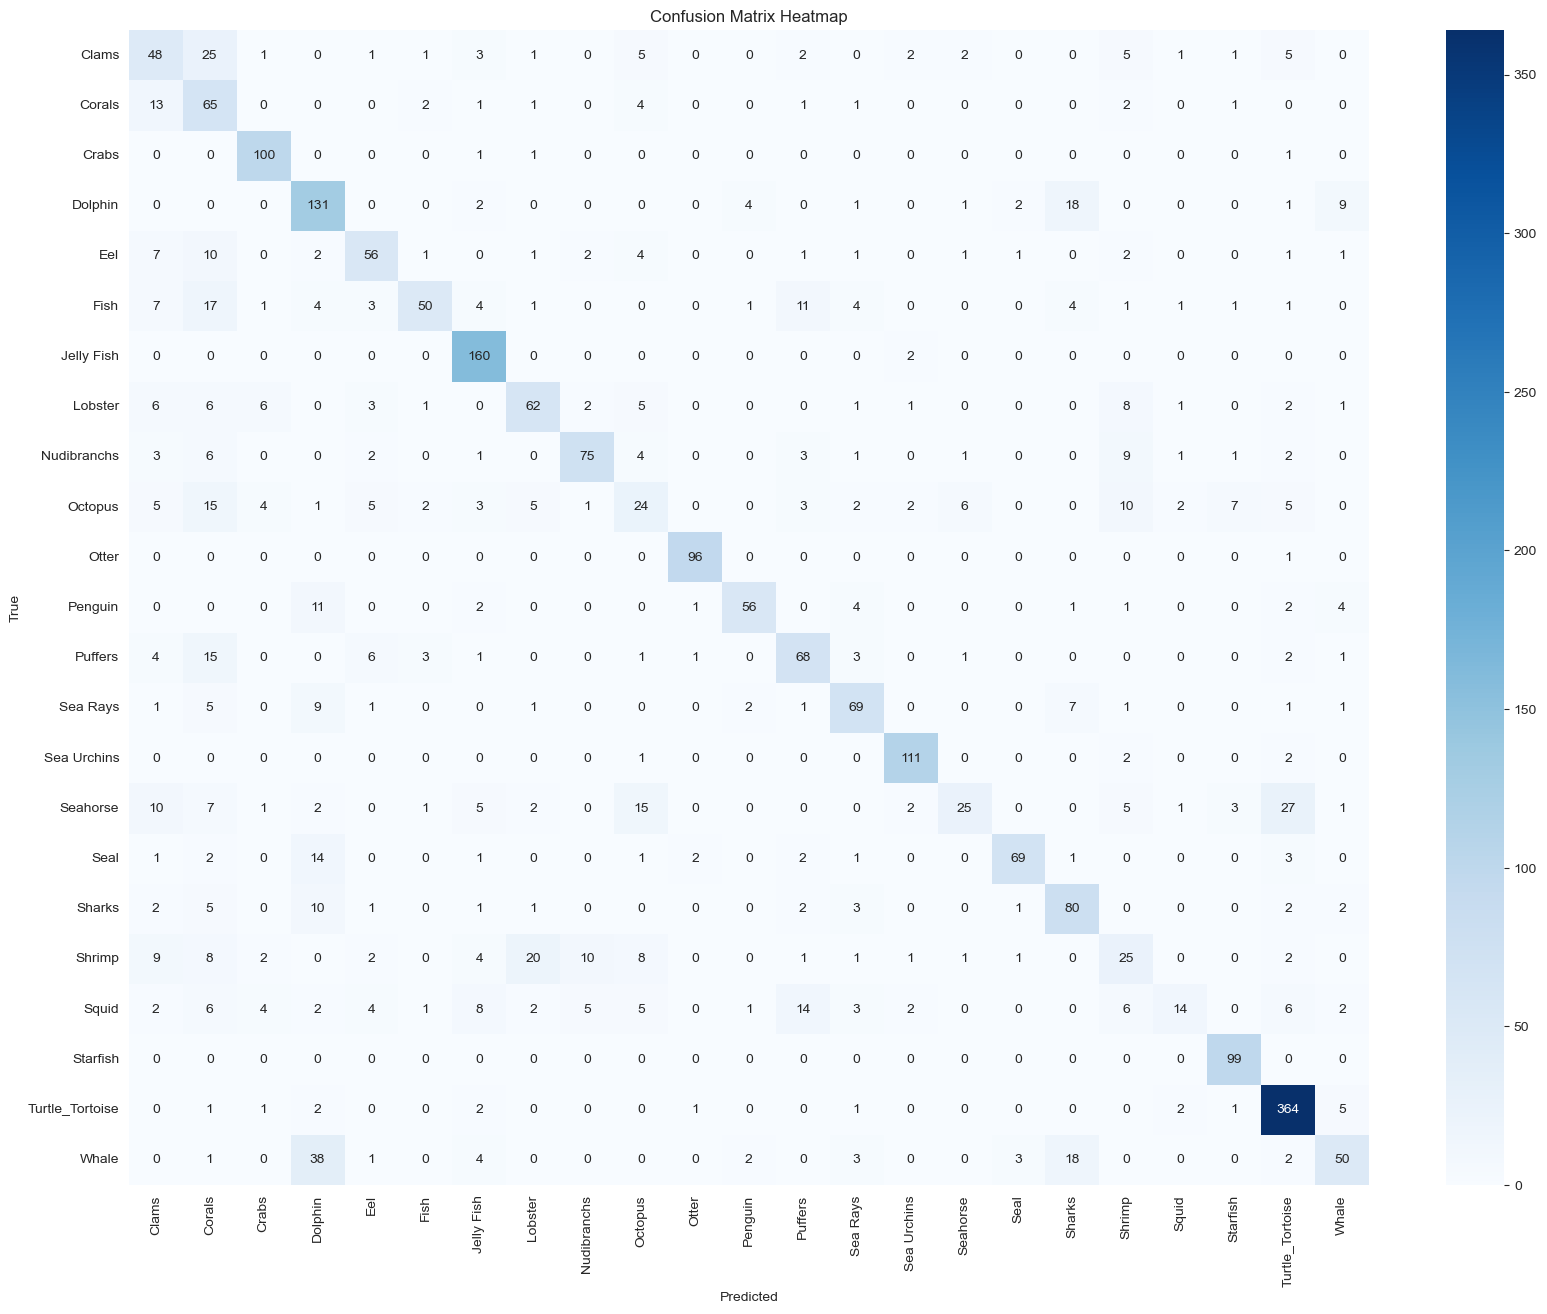

In [54]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, pred, labels=class_labels)

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

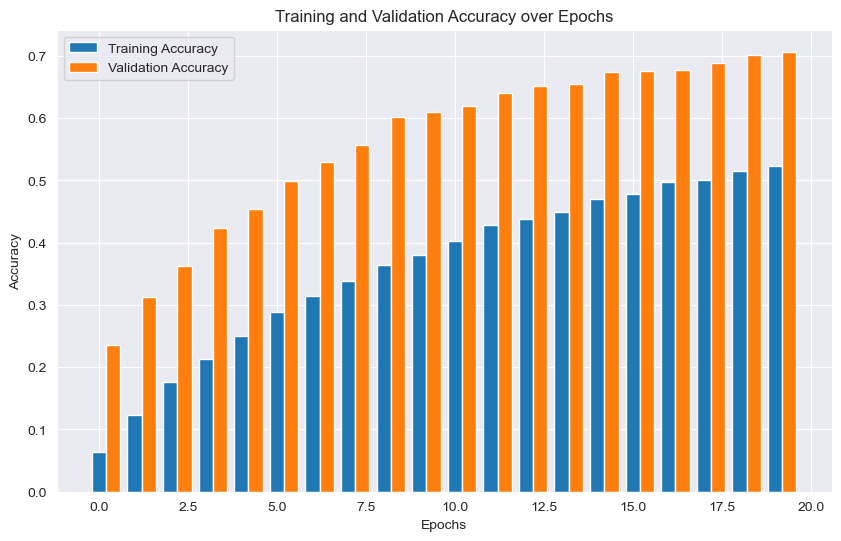

In [55]:
# Plotting the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.bar(epochs, accuracy, width=0.4, label='Training Accuracy', align='center')
plt.bar([e + 0.4 for e in epochs], val_accuracy, width=0.4, label='Validation Accuracy', align='center')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()